R² Score: 0.0936
Mean Squared Error: 0.018832


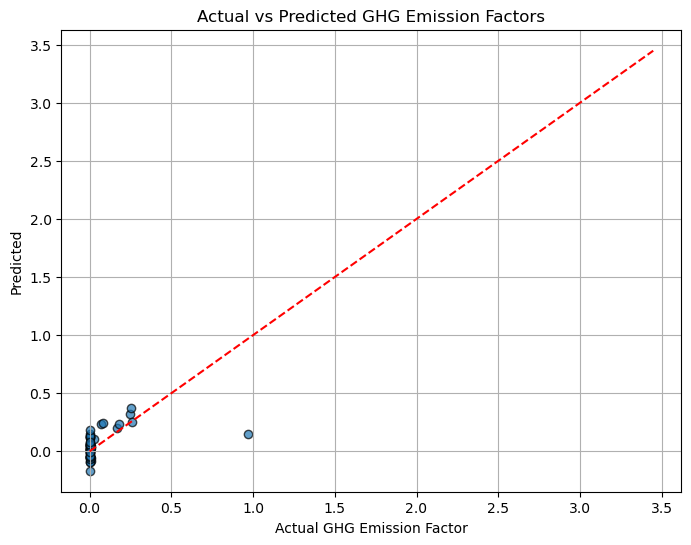

✅ Model and encoders saved.
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Laxmi Magadum\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# ✅ Final GHG Emissions Prediction Code (Shell Edunet)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Step 1: Load the dataset
file_path = "SupplyChainEmissionFactorsforUSIndustriesCommodities.xlsx"
df = pd.read_excel(file_path, sheet_name="2016_Summary_Industry")

# Step 2: Clean and prepare the data
df = df.dropna(subset=['Supply Chain Emission Factors with Margins'])  # keep rows with target

# Step 3: Encode categorical variables
le_industry = LabelEncoder()
le_substance = LabelEncoder()
df['Industry Code'] = le_industry.fit_transform(df['Industry Code'])
df['Industry Name'] = le_industry.fit_transform(df['Industry Name'])
df['Substance'] = le_substance.fit_transform(df['Substance'])

# Step 4: Select features and target
features = [
    'Industry Code',
    'Industry Name',
    'Substance',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins'
]
X = df[features]
y = df['Supply Chain Emission Factors with Margins']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 7: Predict and evaluate
y_pred = model.predict(X_test)
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("Mean Squared Error:", round(mean_squared_error(y_test, y_pred), 6))

# Step 8: Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolors='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual GHG Emission Factor")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted GHG Emission Factors")
plt.grid(True)
plt.show()

# Step 9: Save model and encoders
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/ghg_model.pkl")
joblib.dump(le_industry, "models/industry_encoder.pkl")
joblib.dump(le_substance, "models/substance_encoder.pkl")
print("✅ Model and encoders saved.")

# ------------------
# app.py (API script)
# ------------------

from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load("models/ghg_model.pkl")
le_industry = joblib.load("models/industry_encoder.pkl")
le_substance = joblib.load("models/substance_encoder.pkl")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    try:
        features = [
            le_industry.transform([data['Industry Code']])[0],
            le_industry.transform([data['Industry Name']])[0],
            le_substance.transform([data['Substance']])[0],
            data['DQ_Reliability'],
            data['DQ_Temporal'],
            data['DQ_Geographical'],
            data['DQ_Technological'],
            data['DQ_DataCollection']
        ]
        prediction = model.predict([features])[0]
        return jsonify({"predicted_emission_factor": prediction})
    except Exception as e:
        return jsonify({"error": str(e)})

if __name__ == '__main__':
    app.run(debug=True)
